## Activation Addition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/basic_tutorials/Add_Activations_to_Streams.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "10/06/2023"

### Overview

Interventions have many types: (1) activation swapping, (2) activation addition, or (3) any other kind of operations that modify the activation. In this tutorial, we show how we ca do activation addition.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

[2024-01-11 00:31:07,569] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [5]:
import torch
import pandas as pd
from pyvene.models.basic_utils import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    AdditionIntervention,
    SubtractionIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene.models.gpt2.modelings_intervenable_gpt2 import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual recall with our intervenable module directly

In [8]:
def activation_addition_position_config(model_type, intervention_type, n_layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                i,                 # layer
                intervention_type, # component
                "pos",             # intervention unit
                1,                 # max number of unit
            )
            for i in range(n_layer)
        ],
        intervention_types=AdditionIntervention,
    )
    return config


config, tokenizer, gpt = create_gpt2()

loaded model


In [9]:
config = activation_addition_position_config(
    type(gpt), "mlp_output", gpt.config.n_layer
)

intervenable = IntervenableModel(config, gpt)

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"), tokenizer(source, return_tensors="pt")]
print(base)
res = intervenable(inputs[0])[0]
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = intervenable(inputs[1])[0]
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
_Madrid              0.10501234978437424
_the                 0.0949699655175209
_Barcelona           0.0702790841460228
_a                   0.04010068252682686
_now                 0.02824278175830841
_in                  0.02759990654885769
_Spain               0.022991720587015152
_Catalonia           0.018823225051164627
_also                0.018689140677452087
_not                 0.01735665090382099

The capital of Italy is
_Rome                0.15734916925430298
_the                 0.07316355407238007
_Milan               0.046878915280103683
_a                   0.03449810668826103
_now                 0.03200329467654228
_in                  0.02306535840034485
_also                0.02274816483259201
_home                0.01920313946902752
_not                 0.01640527881681919
_Italy               0.01577090471982956


### We add a word embedding to all MLP streams at the last position
In other tutorials, we often pass in `sources` where each of the example is drawn from the training data. Another way to do patching is, instead of passing in real input example, we pass in activations. These activations can be designed off-line in some particular ways.

In [11]:
# we can patch mlp with the rome word embedding
rome_token_id = tokenizer(" Rome")["input_ids"][0]
rome_embedding = (
    gpt.wte(torch.tensor(rome_token_id)).clone().unsqueeze(0).unsqueeze(0)
)

In [9]:
base = "The capital of Spain is"

_, counterfactual_outputs = intervenable(
    base=tokenizer(base, return_tensors="pt"),
    unit_locations={
        "sources->base": 4
    },  # last position
    source_representations=rome_embedding,
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Rome                0.4558262228965759
_Madrid              0.2788238823413849
_Barcelona           0.10828061401844025
_Valencia            0.015630871057510376
_Lisbon              0.008415448479354382
_the                 0.006678737234324217
_Santiago            0.006526812445372343
_Naples              0.0041163465939462185
_Florence            0.003120437264442444
_Athens              0.0028584974352270365


If you are interested by this work, you can simply think token embeddings at each layer are moved toward the token `_Rome` via the activation addition. Obviouosly, the LM head (which is tied with the embedding matrix) is going to pick out the most similar vectors, which are `_Rome` at the end, and some other countries since they are close to `_Rome`.

You can also read more about this in this paper: [Language Models Implement Simple Word2Vec-style Vector Arithmetic](https://arxiv.org/abs/2305.16130).

### Let's have a more systematic analysis of the addition effect of MLP and MHA streams
We add the word embedding till the `i`-th layer of these streams

In [18]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")
base = tokenizer("The capital of Spain is", return_tensors="pt")

data = []
for till_layer_i in range(gpt.config.n_layer):
    config = activation_addition_position_config(
        type(gpt), "mlp_output", till_layer_i + 1
    )
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            unit_locations={"sources->base": pos_i},
            source_representations=rome_embedding,
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"mlp_o{till_layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    config = activation_addition_position_config(
        type(gpt), "attention_output", till_layer_i + 1
    )
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            unit_locations={
                "sources->base": pos_i
            },
            source_representations=rome_embedding,
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"attn_o{till_layer_i}",
                    "pos": pos_i,
                    "type": "attention_output",
                }
            )
df = pd.DataFrame(data)

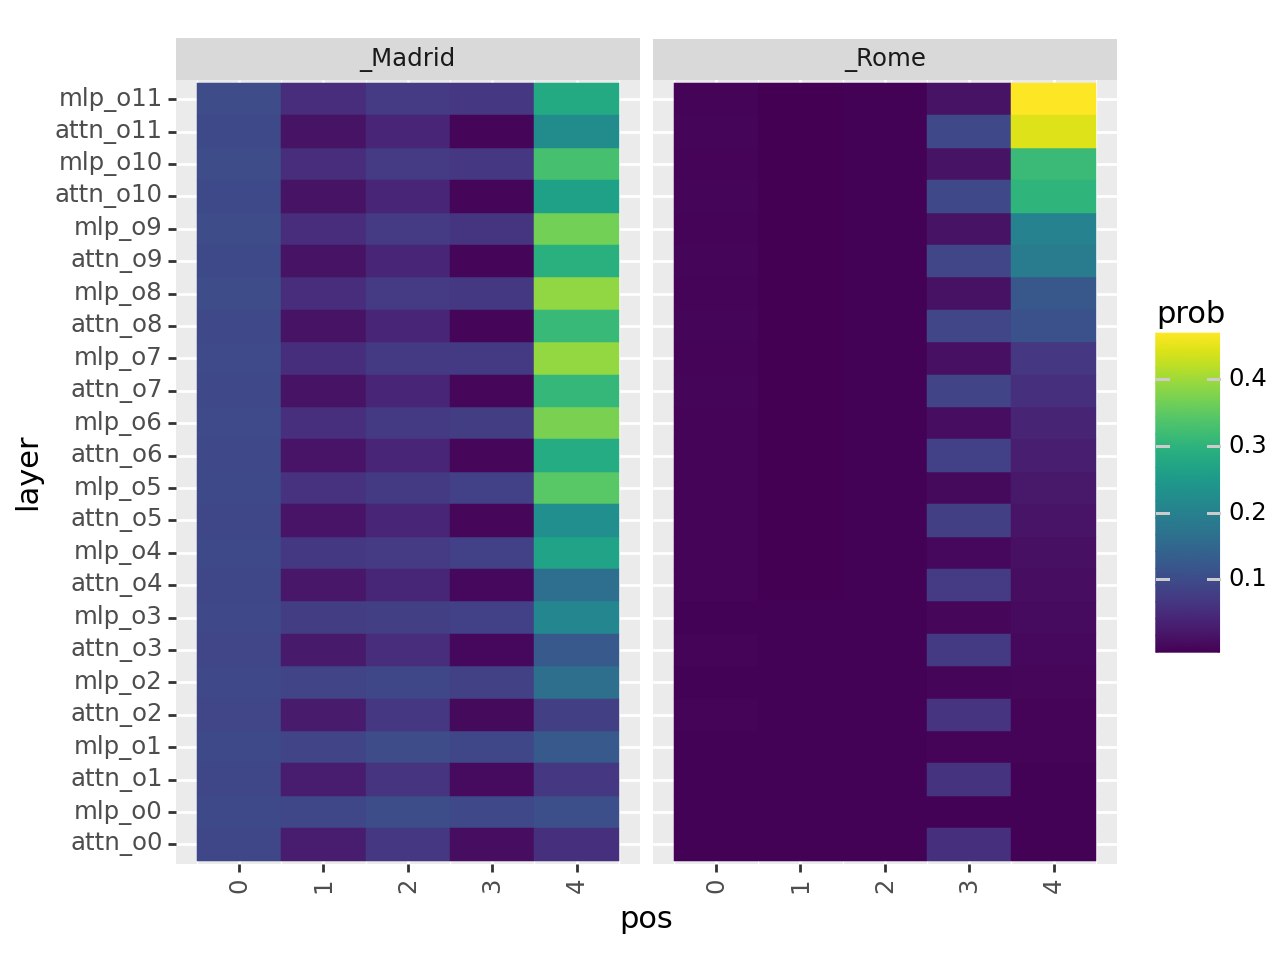

In [19]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"mlp_o{l}")
    nodes.append(f"attn_o{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)